# Exploratory notebook
This is an exploratory notebook to understand how `OrderBike` works. It uses `UrbanToyGraph` to generate toy networks.

In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import shapely

from orderbike import metrics
from orderbike import utils as ordut
from utg import create_graph
from utg import utils as utgut

## Directness
Let's see how directness works. Let's create a network, and take a pair of node as an origin and a destination

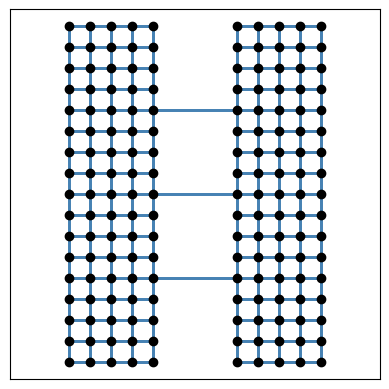

In [2]:
G = create_graph.create_bridge_graph(outrows=4, sscols=5, bridges=3, blength=200)
G = utgut.make_osmnx_compatible(G)
utgut.plot_graph(G)

In [3]:
orig = 0
dest = 85
print(G.nodes[orig], G.nodes[dest])

{'x': 0, 'y': 0} {'x': 400, 'y': 0}


Using `osmnx.routing.shortest_path` we can use weighted Djikstra's algorithm to find the shortest network path between the two:

In [4]:
route = ox.routing.shortest_path(G, orig, dest, weight="length")
route

[0, 17, 34, 51, 68, 69, 70, 71, 72, 89, 88, 87, 86, 85]

We can then plot the route using `osmnx.plot_graph_route`:

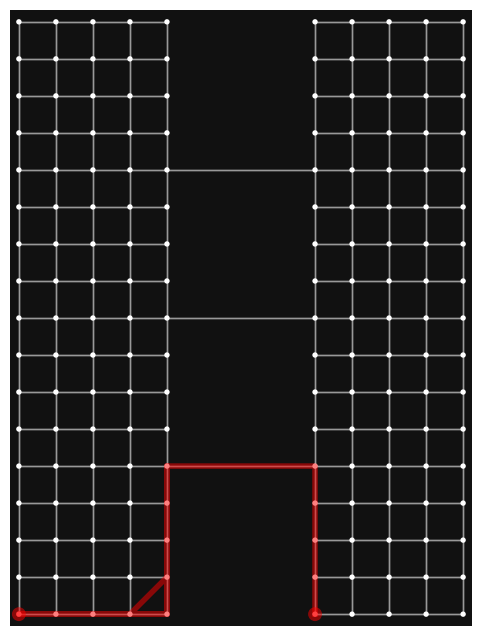

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph_route(G, route)

To compute the directness, we first compute the shortest network path length:

In [6]:
sm = metrics.get_shortest_network_path_matrix(G)
sm[orig][dest]

800.0

Then, we compute the euclidean distance between the node:

In [7]:
em = metrics.get_euclidean_distance_matrix(G, lonlat=False)
em[orig][dest]

400.0

We then divide the euclidean distance by the shortest network path length. The value is 0 if the nodes are from different components, thus (i.e. no possible path between the two nodes). It gives us the directness of a path for an OD-pair, 1 being the shortest network path is also the shortest euclidean path, meaning a straight line :

In [8]:
dm = metrics.get_directness_matrix(G, lonlat=False)
dm[orig][dest]

0.5

By doing the mean of the directness of all non-zero values, we get the directness of the network:

In [9]:
metrics.directness_from_matrix(dm)

0.7900126449020083

Let's take a basic square to compute the directness by hand:

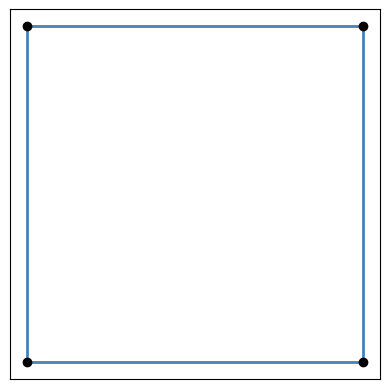

In [10]:
G = create_graph.create_grid_graph(cols=2, rows=2)
utgut.plot_graph(G)

In [11]:
metrics.directness_from_matrix(metrics.get_directness_matrix(G, lonlat=False))

0.9023689270621825

For a square with 4 nodes on each vertex, there are 6 OD pairs, 4 of them are the sides, where the euclidean distance is the shortest network path length, meaning that their directness if 1, 2 of them are the diagonals, where the euclidean distance is $\sqrt{2}$ while the shortest network path is 2, meaning that their directness is $\sqrt{2}/2$. If we compute manually the network directness, we get the same result as above:

In [12]:
(4 * 1 + 2 * np.sqrt(2) / 2) / 6

0.9023689270621825

## Coverage
Coverage is defined as the area that is within reach of the bicycle network. The most naive way to compute it is to create a buffer on the unary union of all edges' geometries:

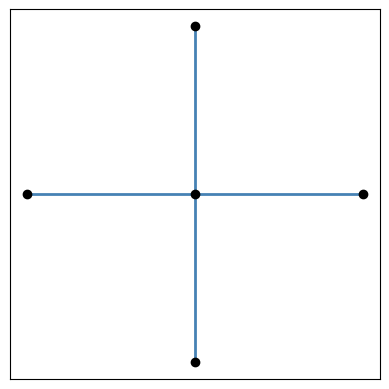

In [13]:
G = create_graph.create_radial_graph()
utgut.plot_graph(G)

The area for a small buffer of 2m is  809.0923879241404


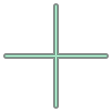

In [14]:
geom = [G.edges[edge]["geometry"] for edge in G.edges]
cov_small_buffer = shapely.unary_union(geom).buffer(2)
print("The area for a small buffer of 2m is ", cov_small_buffer.area)
cov_small_buffer

The area for a large buffer of 50m is  25682.742452723534


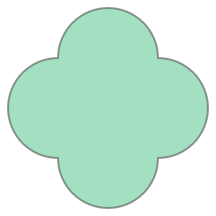

In [15]:
cov_large_buffer = shapely.unary_union(geom).buffer(50)
print("The area for a large buffer of 50m is ", cov_large_buffer.area)
cov_large_buffer

As we can see, when the buffer is larger (or the edges are closer to one another) the same zone is covered by multiple edges, meaning that edges individually do not have the same impact on coverage. To understand how much an edge add value to the coverage, we need to find the relative difference, where we normalize the coverage added by the length of the edge's length:

In [16]:
# TODO FINISH by creating actual functions for coverage

## MultiDiGraph to Graph

Based on the NetworkX definitions, a Graph has bidirectional edges, and there is at most one edge between two different nodes. A DiGraph has directional edges, so you have at most one edge between two different nodes, in a specific direction. A MultiGraph can have more than one edge between two nodes, and you can have a self-loop where an edge is connected on both ways to the same node. A MultiDiGraph is the combination of a DiGraph and a MultiGraph, so you can have any number of directional edges between any pair of nodes.

![](../plots/type_graph_networkx.png)

For Network Science, the Graph is the most studied one, where there is the highest number of metrics. For GIS, the MultiDiGraph is the best representation of a street network, as cars can only go in one direction, and you can have branching streets for the same pair of nodes, and self-loops where a street start and end at the same point.

OSMnx gets the street network from OSM as a MultiDiGraph. There are functions to transform this MultiDiGraph to a MultiGraph (removing directional edges), or to a DiGraph (removing parallel edges by minimizing the weight attribute and erasing self-loops). We created a function to transform it into a Graph while keeping all edges by adding artificial nodes 1 for parallel edges, 2 for self-loops.

![](../plots/multidigraph_to_graph.png)

The upside of this method is that while conserving the topology of the street network and keeping all edges, we get the Graph type to use. The downside of this method is that we add artificial nodes and edges that don't have meaning and can disturb nodes or edges metrics.

We create a toy graph with parallel edges and a self-loop:

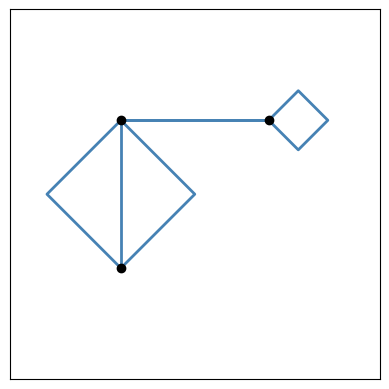

networkx.classes.multidigraph.MultiDiGraph

In [17]:
G = nx.MultiDiGraph()
G.add_node(0, x=0, y=0)
G.add_node(1, x=0, y=1)
G.add_node(2, x=1, y=1)
G.add_edge(1, 0, 2, geometry=shapely.LineString([[0, 1], [-0.5, 0.5], [0, 0]]))
G.add_edge(0, 1, 0, geometry=shapely.LineString([[0, 0], [0, 1]]))
G.add_edge(0, 1, 1, geometry=shapely.LineString([[0, 0], [0.5, 0.5], [0, 1]]))
G.add_edge(1, 2, geometry=shapely.LineString([[0, 1], [1, 1]]))
G.add_edge(2, 1, geometry=shapely.LineString([[1, 1], [0, 1]]))
G.add_edge(
    2,
    2,
    geometry=shapely.LineString([[1, 1], [1.2, 0.8], [1.4, 1], [1.2, 1.2], [1, 1]]),
)
for e in G.edges:
    G.edges[e]["length"] = G.edges[e]["geometry"].length
utgut.plot_graph(G, rel_buff=1.5)
type(G)

Since we are using the `osmnx.get_undirected` function, we need to first make our graph osmnx compatible, then we can transform it. The reason why we are using it is that otherwise if doing a simple `networkx.MultiGraph` on the graph, some edges might be lost. OSMnx ensure that all edges with a different geometry for a same pair of nodes are kept.

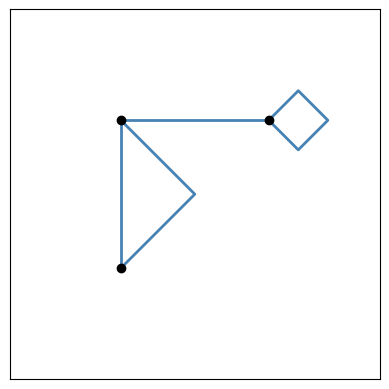

networkx.classes.multigraph.MultiGraph

In [18]:
H = nx.MultiGraph(G)
utgut.plot_graph(H, rel_buff=1.5)
type(H)

Using our function, we add one node for each parallel edges so two, and two nodes for the self-loop:

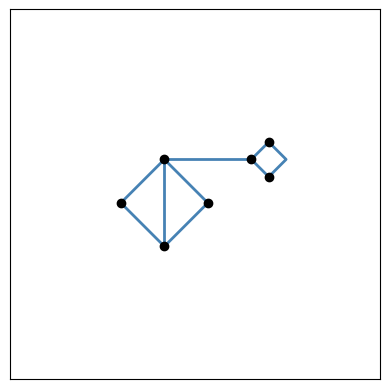

networkx.classes.graph.Graph

In [19]:
G = utgut.make_osmnx_compatible(G)
G = ordut.multidigraph_to_graph(G)
utgut.plot_graph(G, rel_buff=1.5)
type(G)

## Test disconnected component

### Basic case
A potential constraint in the order of construction is to keep the network connected. This is understandable, as connectivity is an important factor for cyclist uptake, but it's also limiting options on where to build. Especially if there are already built part, it means that you would only build where there are facilities already, which can be reproduce existing inequalities.

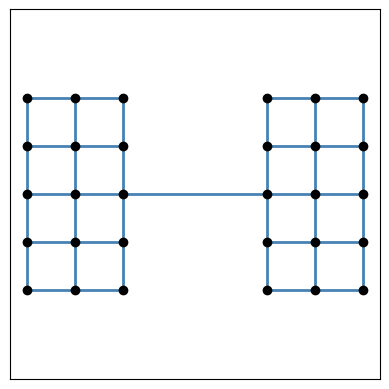

1

In [20]:
G = create_graph.create_bridge_graph(outrows=2, bridges=1)
utgut.plot_graph(G)
nx.number_connected_components(G)

If we remove the edge making the bridge, it will create a new component:

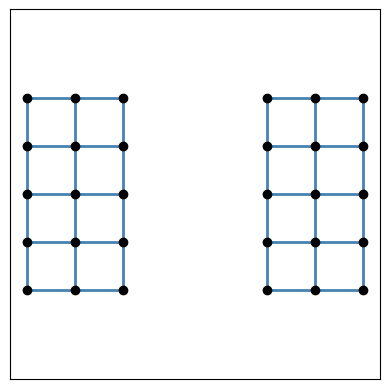

2

In [21]:
H = G.copy()
H.remove_edge(12, 17)
utgut.plot_graph(H)
nx.number_connected_components(H)

We can check that the number of component increases when removing an edge by comparing the two:

In [22]:
if nx.number_connected_components(H) > nx.number_connected_components(G):
    print(
        f"There are new components, we started at {nx.number_connected_components(G)} and we are at {nx.number_connected_components(H)}."
    )

There are new components, we started at 1 and we are at 2.


### Subtractive removal leaving isolated node
But when removing edges, if we don't remove isolated nodes, a new component can be created with a single node:

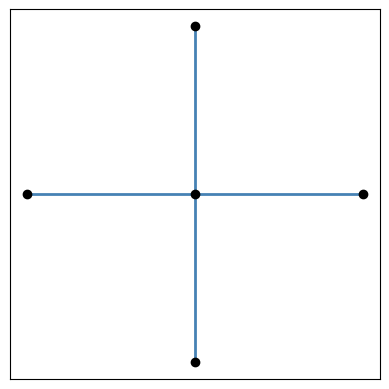

1

In [23]:
G = create_graph.create_radial_graph()
utgut.plot_graph(G)
nx.number_connected_components(G)

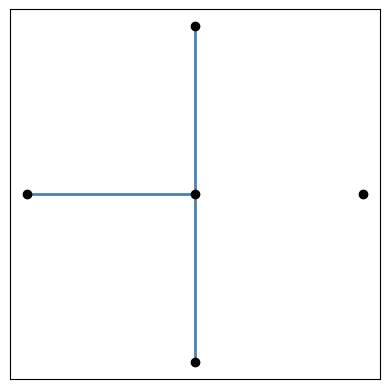

2

In [24]:
H = G.copy()
H.remove_edge(0, 1)
utgut.plot_graph(H)
nx.number_connected_components(H)

A way to avoid accounting for such component is either to remove isolated nodes:

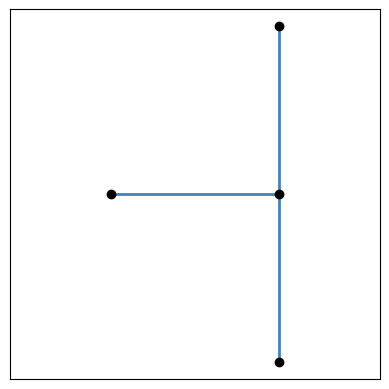

1

In [25]:
H_clean = H.copy()
H_clean = ordut.clean_isolated_node(H_clean)
utgut.plot_graph(H_clean)
nx.number_connected_components(H_clean)

Or, when we are testing, instead of looking only at the number of components if it increases, add a condition on the fact that if the number of components increases, there are no components with only one node:

In [26]:
if nx.number_connected_components(H) > nx.number_connected_components(G):
    print(
        f"There are new components, we started at {nx.number_connected_components(G)} and we are at {nx.number_connected_components(H)}."
    )
    for cc in list(nx.connected_components(H)):
        if len(cc) == 1:
            print("But there is a new component with a single node.")
            break

There are new components, we started at 1 and we are at 2.
But there is a new component with a single node.


### Subtractive removal with a built network that is made of multiple components

Since we are working on finding the right order of construction, a component can be added in the subtractive order if it means that we are keeping only the built components. To identify them, we choose what we call elected nodes, that are nodes on each built components. If there is a new component but that new component is hosting built nodes, then we accept it:

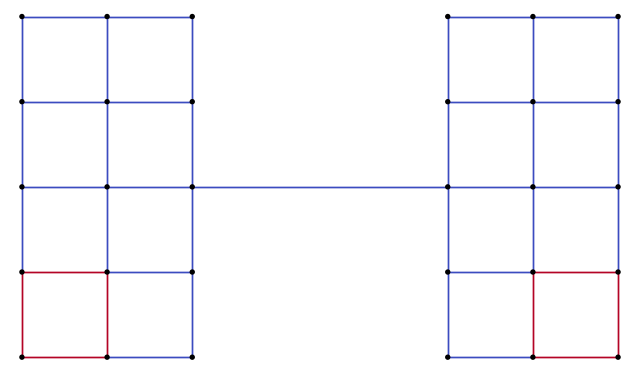

1

In [27]:
G = create_graph.create_bridge_graph(outrows=2, bridges=1)
for edge in G.edges:
    G.edges[edge]["built"] = 0
G.edges[0, 1]["built"] = 1
G.edges[0, 5]["built"] = 1
G.edges[1, 6]["built"] = 1
G.edges[5, 6]["built"] = 1
G.edges[20, 21]["built"] = 1
G.edges[20, 25]["built"] = 1
G.edges[21, 26]["built"] = 1
G.edges[25, 26]["built"] = 1
G_plot = utgut.make_osmnx_compatible(G)  # For visualization
ec = ox.plot.get_edge_colors_by_attr(G_plot, "built", cmap="coolwarm")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)
nx.number_connected_components(G)

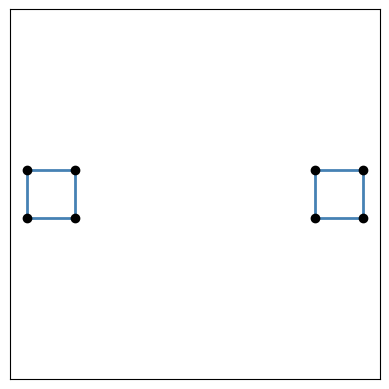

Edges in the build graph: [(0, 5), (0, 1), (1, 6), (5, 6), (20, 25), (20, 21), (21, 26), (25, 26)]


In [28]:
built_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
G_built = G.edge_subgraph(built_edges)
utgut.plot_graph(G_built)
print("Edges in the build graph:", built_edges)

In [29]:
list(nx.connected_components(G_built))

[{0, 1, 5, 6}, {20, 21, 25, 26}]

In [30]:
elected_nodes = [next(iter(cc)) for cc in list(nx.connected_components(G_built))]
print("Elected nodes are:", elected_nodes)

Elected nodes are: [0, 25]


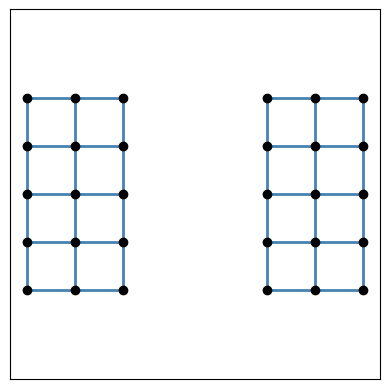

2

In [31]:
H = G.copy()
H.remove_edge(12, 17)
utgut.plot_graph(H)
nx.number_connected_components(H)

In [32]:
# TODO: Find smarter way to loop
if nx.number_connected_components(H) > nx.number_connected_components(G):
    print(
        f"There are new components, we started at {nx.number_connected_components(G)} and we are at {nx.number_connected_components(H)}."
    )
    for idx, cc in enumerate(list(nx.connected_components(H))):
        test = False
        for node in elected_nodes:
            if node in cc:
                print(
                    f"Component {idx} is with a built part, as shown by the presence of the node {node}"
                )
                test = True
        if not test:
            print(f"Component {idx} is without any built part !")

There are new components, we started at 1 and we are at 2.
Component 0 is with a built part, as shown by the presence of the node 0
Component 1 is with a built part, as shown by the presence of the node 25


### Restrict the potential cases by finding all bridges of the graph

If we create a new component by the removal of an edge, it means that the edge is a bridge of the network. Since if we want to keep the network connected this is an illegal move, we can optimize our search by first finding all bridges and remove them from the tested edges:

In [ ]:
# TODO: Use networkx.bridges

The hard part is more than we then need to ensure to keep acceptable bridges, being the one where the additional component is one where there is a built component to it.

In [1]:
# TODO: Run on the bridges to see if all components are connected to the built roots, if so make them again valid edges

### Additive order with necessary new component

In the case that in the final graph there is another component compared to the initial graph, we need to make sure that the new component is part of this final component.

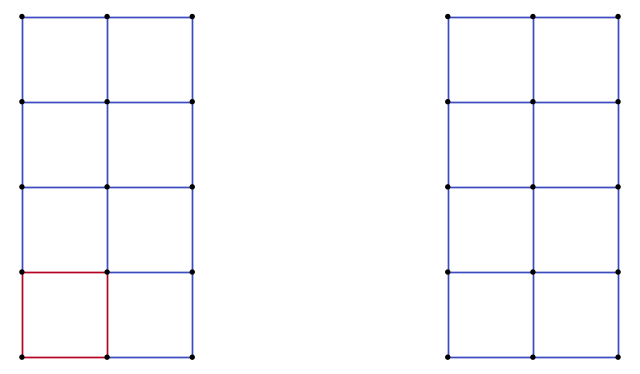

2

In [33]:
G = create_graph.create_bridge_graph(outrows=2, bridges=1)
G.remove_edge(12, 17)
for edge in G.edges:
    G.edges[edge]["built"] = 0
G.edges[0, 1]["built"] = 1
G.edges[0, 5]["built"] = 1
G.edges[1, 6]["built"] = 1
G.edges[5, 6]["built"] = 1
G_plot = utgut.make_osmnx_compatible(G)  # For visualization
ec = ox.plot.get_edge_colors_by_attr(G_plot, "built", cmap="coolwarm")
ox.plot_graph(G_plot, bgcolor="white", node_color="black", edge_color=ec)
nx.number_connected_components(G)

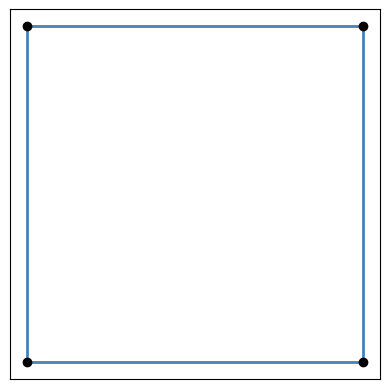

Edges in the build graph: [(0, 5), (0, 1), (1, 6), (5, 6)]


1

In [34]:
built_edges = [edge for edge in G.edges if G.edges[edge]["built"] == 1]
G_built = G.edge_subgraph(built_edges)
utgut.plot_graph(G_built)
print("Edges in the build graph:", built_edges)
nx.number_connected_components(G_built)

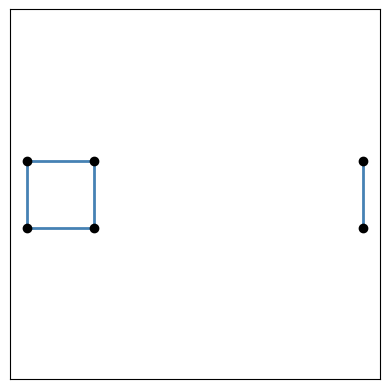

2

In [35]:
new_edges = built_edges
new_edges.append(tuple([15, 16]))
H = G.edge_subgraph(new_edges)
utgut.plot_graph(H)
nx.number_connected_components(H)

To do so, we use the same technique of elected nodes as for the subtractive order with the built part, but on the final graph:

In [36]:
elected_nodes = [next(iter(cc)) for cc in list(nx.connected_components(G))]
print("Elected nodes are:", elected_nodes)

Elected nodes are: [0, 15]


In [37]:
if nx.number_connected_components(H) > nx.number_connected_components(G_built):
    print(
        f"There are new components, we started at {nx.number_connected_components(G_built)} and we are at {nx.number_connected_components(H)}."
    )
    for idx, cc in enumerate(list(nx.connected_components(H))):
        test = False
        for node in elected_nodes:
            if node in cc:
                print(
                    f"Component {idx} is a component of the final graph, as shown by the presence of the node {node}"
                )
                test = True
        if not test:
            print(f"Component {idx} is not a necessary component !")

There are new components, we started at 1 and we are at 2.
Component 0 is a component of the final graph, as shown by the presence of the node 0
Component 1 is a component of the final graph, as shown by the presence of the node 15


## Workflow for growth